# Exploratory visualization on combined dataset [Covid rate, Covid Vaccination and Stock targeting EU]

### Below python code extracts the data from Azure cloud based postgreSQLfrom different tables 

#### Author: 

 1. Rohan Indrajeet Jadhav [x20169043@student.ncirl.ie]
 2. Jorden Anthon Lopes  [x19213344@student.ncirl.ie]
 3. Aniket Jambukar  [x20185014@student.ncirl.ie]

#### Contents

1. Extract the data from Azure cloud from tables [stockdata, covidvaccination, covid_rate]
2. Preprocessing:
    a. Handling NULL/ Blank values
    b. Datatype fixes
    c. Aggregation on certain fields
3. Comparative visualization which depicts stock prices against covid vaccination and covid rate
4. Perform resampling whenever required

In [2]:
# importing all required libraries....
import pymongo
from pprint import pprint  
import pandas as pd
import yfinance as yf
import psycopg2

from pandas_datareader import data, wb
import numpy as np
import datetime
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from subprocess import check_output
from matplotlib import dates
import warnings
from datetime import datetime as dt
from datetime import timedelta
import os


In [3]:

# Update connection string information
host = "postgresqlserver11.postgres.database.azure.com"
dbname = "covidstockanalysis"
user = "covidstock@postgresqlserver11"
password = "rjadha14!123"
sslmode="require"


In [4]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:

# Construct connection string
conn_string = "host={0} user={1} dbname={2} password={3} sslmode={4}".format(host, user, dbname, password, sslmode)
azureConnection = psycopg2.connect(conn_string)
print("Connection established")
psycopg2.__version__


Connection established


'2.8.6 (dt dec pq3 ext lo64)'

### Plotting the line chart for benchmarked stock weighing the average of largest listed companies

In [7]:
### importing data from cloud dB server 
###  for data visualization fetching data from cloud database.
### Below query gives the result by joining three datasets
### 1. Covid rates
### 2. Covid vaccination
### 3. Stock data
### Extracts the TOP 5 stocks data falls under European region 
### and do aggregation on this for aligning the data to covid rates and vaccination

column_names = ['date','at1Dose', 'fullVaccinate', 'openvalue','total_cases']

query = """select Table2.date ,c1.at1Dose,c1.fullVaccinate,Table2.openvalue,Table2.total_cases from 
(
select sum(atleast1dose) at1Dose,sum(fullvaccination) fullVaccinate,date from (select date,atleast1dose,fullvaccination from covidvaccination)m
group by m.date order by date
) c1
right join 
(select Covidrate.total_cases,Covidrate.date,stock.openvalue from 
(select sum(new_cases) as total_cases,date from 
(select * from covid_rate)M group by date order by date) Covidrate
left join 
(
select stockdate, round(avg(openvalue),2) as openvalue from stockdata11 t1,
(select stockname, max(openvalue), min(openvalue) from stockdata11
group by stockname 
order by 2 desc
FETCH FIRST 5 ROW ONLY) t2
where t1.stockname = t2.stockname
group by t1.stockdate
order by t1.stockdate) stock on Covidrate.date=stock.stockdate
) Table2 on c1.date=Table2.date  order by Table2.date ;"""


azureCursor = azureConnection.cursor()
azureCursor.execute(query)
rows = azureCursor.fetchall()


completeDF = pd.DataFrame(rows, columns=column_names)


print("Operation done successfully")
#azureConnection.close()

completeDF

Operation done successfully


,date,at1Dose,fullVaccinate,openvalue,total_cases
0,2020-02-23,NaN,NaN,None,93
1,2020-02-24,NaN,NaN,1803.12,74
2,2020-02-25,NaN,NaN,191.67,93
3,2020-02-26,NaN,NaN,188.36,131
4,2020-02-27,NaN,NaN,184.66,202
...,...,...,...,...,...
402,2021-03-31,40130105.0,17638500.0,228.41,210639
403,2021-04-01,34009600.0,13964596.0,232.61,196272
404,2021-04-02,34288233.0,13673660.0,None,169319
405,2021-04-03,36875820.0,16448050.0,None,114382


In [8]:
# data processing before rendering for visualization 
# replacing all NAN values to 0

completeDF['total_cases'] = completeDF['total_cases'].fillna(0)
completeDF['at1Dose'] = completeDF['at1Dose'].fillna(0)
completeDF['fullVaccinate'] = completeDF['fullVaccinate'].fillna(0)
completeDF['openvalue'] = completeDF['openvalue'].fillna(0)

# below two columns are in string format for processing we converted them into flot format
completeDF['openvalue']  = completeDF.openvalue.astype(str).astype(float)
completeDF['total_cases'] = completeDF.total_cases.astype(str).astype(float)

# Date column was in string format ,we converted it into datetime format
completeDF['date']= pd.to_datetime(completeDF['date'])
completeDF.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407 entries, 0 to 406
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           407 non-null    datetime64[ns]
 1   at1Dose        407 non-null    float64       
 2   fullVaccinate  407 non-null    float64       
 3   openvalue      407 non-null    float64       
 4   total_cases    407 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 16.0 KB


### Line Chart: Covid rate, Covid vaccination and benchmarked stock

numpy.ndarray

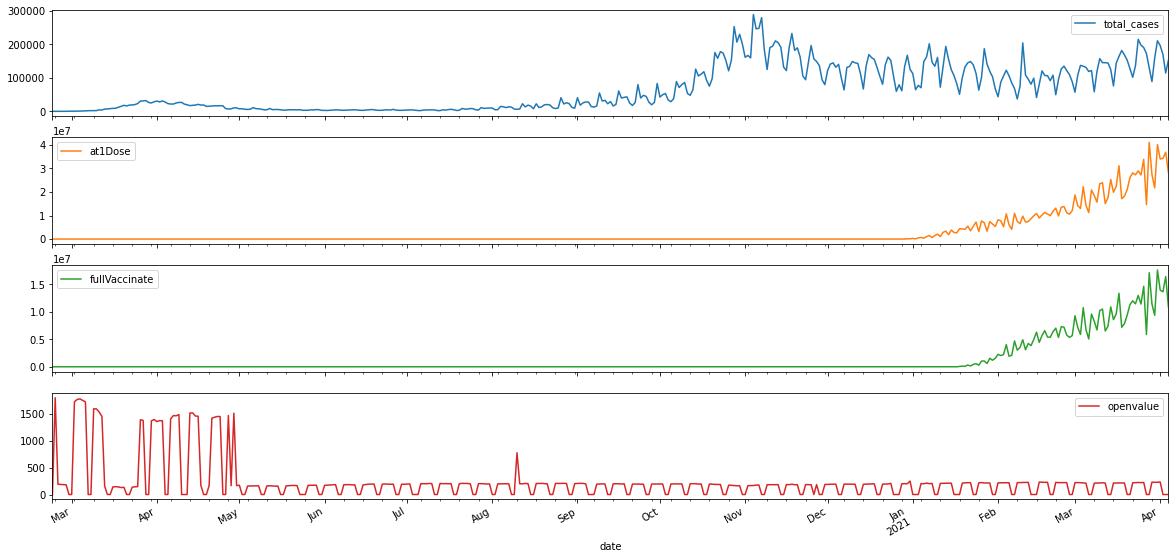

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mt

# for comparison we have selected list of features which we want to compare 
completeDF2 = completeDF[['date','total_cases','at1Dose','fullVaccinate','openvalue' ]]

completeDF2.set_index('date',inplace=True)

completeDF2

axes = completeDF2.plot.line(subplots=True,figsize=(20,10))
type(axes)


In [10]:
# segregated month wise record and took sum of all values  ,for month wise data  representation 

df_week = completeDF.resample("M",on='date').sum()
df_week = df_week.reset_index()
# segregated dates from Date column which carries DD-MM-YY record
df_week['date'] = df_week['date'].dt.date

df_week.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15 non-null     object 
 1   at1Dose        15 non-null     float64
 2   fullVaccinate  15 non-null     float64
 3   openvalue      15 non-null     float64
 4   total_cases    15 non-null     float64
dtypes: float64(4), object(1)
memory usage: 728.0+ bytes


In [15]:
### replacing Nan values to 0
completeDF['total_cases'] = completeDF['total_cases'].fillna(0)
completeDF['at1Dose'] = completeDF['at1Dose'].fillna(0)
completeDF['fullVaccinate'] = completeDF['fullVaccinate'].fillna(0)
completeDF['openvalue'] = completeDF['openvalue'].fillna(0)

### conversion of object type values to float format
### conversion of object type values to date format
completeDF['openvalue']  = completeDF.openvalue.astype(str).astype(float)
completeDF['total_cases'] = completeDF.total_cases.astype(str).astype(float)
completeDF['date']= pd.to_datetime(completeDF['date'])

completeDF

,date,at1Dose,fullVaccinate,openvalue,total_cases
0,2020-02-23,0.0,0.0,0.00,93.0
1,2020-02-24,0.0,0.0,49.01,74.0
2,2020-02-25,0.0,0.0,49.89,93.0
3,2020-02-26,0.0,0.0,48.82,131.0
4,2020-02-27,0.0,0.0,48.43,202.0
...,...,...,...,...,...
402,2021-03-31,40130105.0,17638500.0,49.40,210639.0
403,2021-04-01,34009600.0,13964596.0,49.35,196272.0
404,2021-04-02,34288233.0,13673660.0,0.00,169319.0
405,2021-04-03,36875820.0,16448050.0,0.00,114382.0


### Plotting the line chart for benchmarked stock which falls at EU level

In [7]:
###  for data visualization fetching data from cloud database.
### Below query gives the result by joining three datasets
### 1. Covid rates
### 2. Covid vaccination
### 3. Stock data
### Extract the stock data for European region and do aggregation on this for aligning the data to covid rates and vaccination

column_names = ['date','at1Dose', 'fullVaccinate', 'openvalue','total_cases']

query = """select Table2.date ,c1.at1Dose,c1.fullVaccinate,Table2.openvalue,Table2.total_cases from 
(
select sum(atleast1dose) at1Dose,sum(fullvaccination) fullVaccinate,date from (select date,atleast1dose,fullvaccination from covidvaccination)m
group by m.date order by date
) c1
right join 
(select Covidrate.total_cases,Covidrate.date,stock.openvalue from 
(select sum(total_cases) as total_cases,date from 
(select * from covid_rate)M group by date order by date) Covidrate
left join 
(
select stockdate, round(avg(openvalue),2) as openvalue from stockdata11 t1,
(select stockname, max(openvalue), min(openvalue) from stockdata11 where countryname = 'European'
group by stockname ) t2
where t1.stockname = t2.stockname
group by t1.stockdate
order by t1.stockdate) stock on Covidrate.date=stock.stockdate
) Table2 on c1.date=Table2.date  order by Table2.date ;
"""


azureCursor = azureConnection.cursor()
azureCursor.execute(query)
rows = azureCursor.fetchall()

completeDF = pd.DataFrame(rows, columns=column_names)


print("Operation done successfully")
#azureConnection.close()

completeDF



Operation done successfully


,date,at1Dose,fullVaccinate,openvalue,total_cases
0,2020-02-23,NaN,NaN,None,93
1,2020-02-24,NaN,NaN,65.80,167
2,2020-02-25,NaN,NaN,65.76,260
3,2020-02-26,NaN,NaN,64.65,391
4,2020-02-27,NaN,NaN,63.60,593
...,...,...,...,...,...
414,2021-04-12,NaN,NaN,None,2888563
415,2021-04-13,NaN,NaN,None,2892123
416,2021-04-14,NaN,NaN,None,2900259
417,2021-04-15,NaN,NaN,None,2909245


In [8]:

completeDF['openvalue']  = completeDF.openvalue.astype(str).astype(float)
completeDF['total_cases'] = completeDF.total_cases.astype(str).astype(float)

completeDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419 entries, 0 to 418
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           419 non-null    object 
 1   at1Dose        104 non-null    float64
 2   fullVaccinate  104 non-null    float64
 3   openvalue      284 non-null    float64
 4   total_cases    419 non-null    float64
dtypes: float64(4), object(1)
memory usage: 16.5+ KB


In [9]:
completeDF['total_cases'] = completeDF['total_cases'].fillna(0)
completeDF['at1Dose'] = completeDF['at1Dose'].fillna(0)
completeDF['fullVaccinate'] = completeDF['fullVaccinate'].fillna(0)
completeDF['openvalue'] = completeDF['openvalue'].fillna(0)
completeDF.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419 entries, 0 to 418
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           419 non-null    object 
 1   at1Dose        419 non-null    float64
 2   fullVaccinate  419 non-null    float64
 3   openvalue      419 non-null    float64
 4   total_cases    419 non-null    float64
dtypes: float64(4), object(1)
memory usage: 16.5+ KB


In [10]:
completeDF['openvalue']  = completeDF.openvalue.astype(str).astype(float)
completeDF['total_cases'] = completeDF.total_cases.astype(str).astype(float)
completeDF['date']= pd.to_datetime(completeDF['date'])


In [11]:
#y axis intervals for covid rate and vaccination should be same

df_week = completeDF.resample("M",on='date').max()
df_week
"""
axes = df_week.plot.line(subplots=True,figsize=(20,15))
#df.week.drop('date', axis = 1, inplace = True)


df12=df_week[['at1Dose','fullVaccinate','openvalue','total_cases']]

type(axes)
"""

"\naxes = df_week.plot.line(subplots=True,figsize=(20,15))\n#df.week.drop('date', axis = 1, inplace = True)\n\n\ndf12=df_week[['at1Dose','fullVaccinate','openvalue','total_cases']]\n\ntype(axes)\n"

In [12]:
df12=df_week[['at1Dose','fullVaccinate','openvalue','total_cases']]

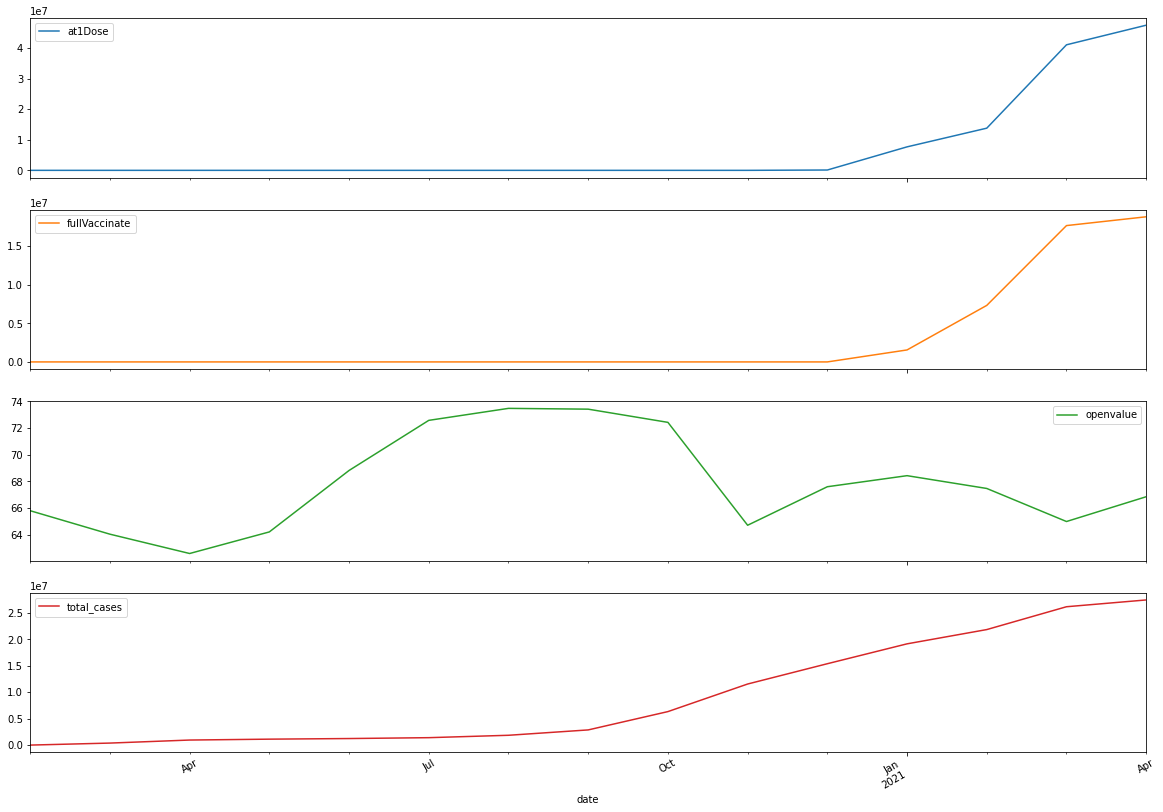

In [13]:
# depicts month wise progress and movements in features of dataset 
axes = df12.plot.line(subplots=True,figsize=(20,15))

In [14]:
df_week.head()

,date,at1Dose,fullVaccinate,openvalue,total_cases
date,,,,,
2020-02-29,2020-02-29,0.0,0.0,65.80,1066.0
2020-03-31,2020-03-31,0.0,0.0,64.04,381268.0
2020-04-30,2020-04-30,0.0,0.0,62.59,954172.0
2020-05-31,2020-05-31,0.0,0.0,64.21,1123151.0
2020-06-30,2020-06-30,0.0,0.0,68.82,1238661.0


### Line Chart: Shows the rates of vaccinationatleast 1 dose, fully vaccinated and covid rate

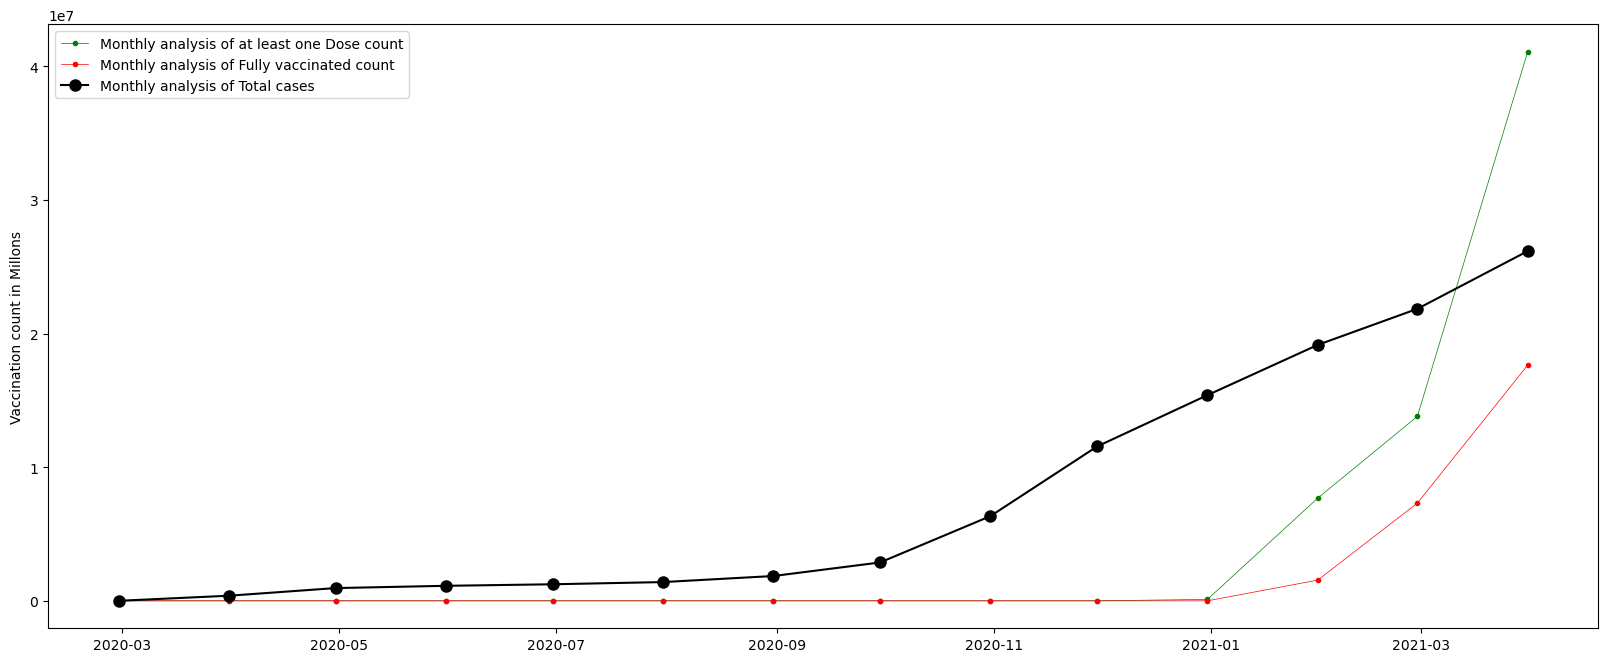

In [17]:
### AUTOMATE THE DATES only for last 4 months #####
### date wise growth in (at least one dose,Fully vaccinated and total cases) features of dataset .
start = datetime.datetime(2019,12,1) 
end = datetime.datetime.now()
fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100
ax.plot(df_week.loc[start:end, 'at1Dose'], marker='.', linestyle='-', linewidth = 0.5, label='Monthly analysis of at least one Dose count', color='green')
ax.plot(df_week.loc[start:end, 'fullVaccinate'], marker='.', linestyle='-', linewidth = 0.5, label='Monthly analysis of Fully vaccinated count', color='red')
# ax.plot(df_week.loc[start:end, 'openvalue'], marker='o', markersize=8, linestyle='-', label='Weekly analysis of one dose distribution', color='Black')
ax.plot(df_week.loc[start:end, 'total_cases'], marker='o', markersize=8, linestyle='-', label='Monthly analysis of Total cases', color='Black')

 

plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100
# label='Monthly', color='violet')
ax.set_ylabel("Vaccination count in Millons")

# rcParams['figure.figsize'] = 11, 9
ax.legend(
)

In [39]:
df_week.head()

,date,at1Dose,fullVaccinate,openvalue,total_cases
date,,,,,
2020-02-29,2020-02-29,0.0,0.0,0.00,1066.0
2020-03-31,2020-03-31,0.0,0.0,0.00,381268.0
2020-04-30,2020-04-30,0.0,0.0,0.00,954172.0
2020-05-31,2020-05-31,0.0,0.0,0.00,1123151.0
2020-06-30,2020-06-30,0.0,0.0,0.00,1238661.0
2020-07-31,2020-07-31,0.0,0.0,0.00,1403414.0
2020-08-31,2020-08-31,0.0,0.0,0.00,1835235.0
2020-09-30,2020-09-30,0.0,0.0,10.80,2871023.0
2020-10-31,2020-10-31,0.0,0.0,11.00,6336956.0


### Horizontal stacked bar chart: for Covid vaccination, covid rates and open values for benchmarked EU stock

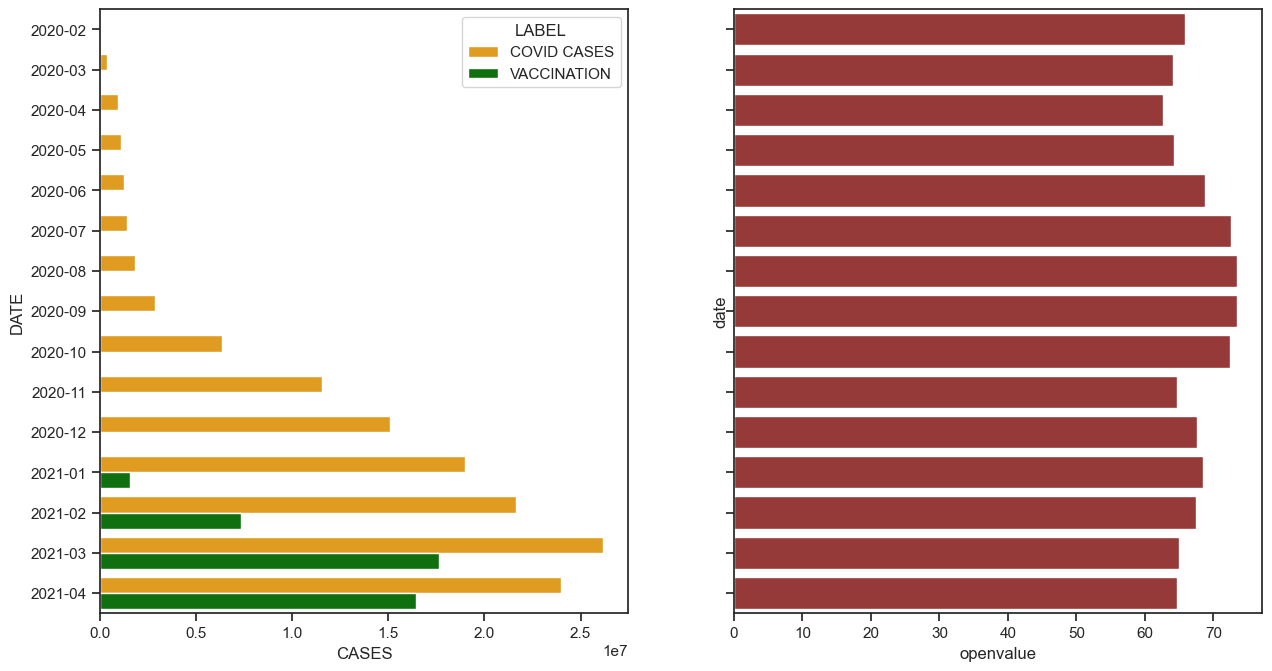

In [207]:
### ploting subplot which shows relationship of rising numer of covid cases with increasing vaccination rate .and shows impact of it on Europian stock market which includes top 5 share values.
sns.set_theme(style="ticks")
custom_palette = ["orange","green"]
sns.set_palette(custom_palette)


tot_case_vacc = pd.DataFrame()
for rec in df_week.date:
    tot_case_vacc = tot_case_vacc.append(pd.DataFrame({'DATE':df_week[df_week.date == rec].date.tolist(), 'CASES':df_week[df_week.date == rec].total_cases.tolist(),'LABEL':'COVID CASES'}))
    tot_case_vacc = tot_case_vacc.append(pd.DataFrame({'DATE':df_week[df_week.date == rec].date.tolist(), 'CASES':df_week[df_week.date == rec].fullVaccinate.tolist(),'LABEL':'VACCINATION'}))


fig_dims = (15, 8)
fig, axes = plt.subplots(1, 2, figsize=fig_dims, sharey=True)

ax = sns.barplot(x="CASES", y=tot_case_vacc['DATE'].dt.strftime('%Y-%m'), hue = 'LABEL', data=tot_case_vacc, ax=axes[0])
ax = sns.barplot(x="openvalue", y=df_week['date'].dt.strftime('%Y-%m'), data=df_week, ax=axes[1], color='brown')
